In [1]:
import torch
from torch import nn

import gzip
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Dataset

Reading 60000 images 28x28 from train-images-idx3-ubyte.gz
Read 60000 labels from train-labels-idx1-ubyte.gz


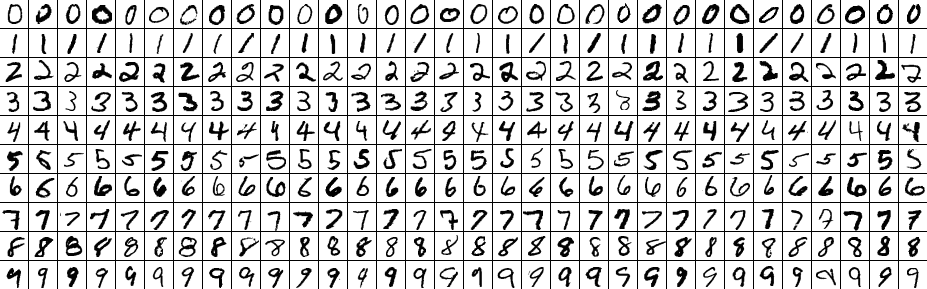

In [2]:
class AccessError(Exception):
    def __init__(self, *vargs, **kwargs):
        super().__init__(*vargs, **kwargs)

class MNIST(torch.utils.data.Dataset):
    """
    MNIST dataset loader from http://yann.lecun.com/exdb/mnist/
    """
    def __init__(self, root='./', train=True, download=True, transform=None, target_transform=None):
        self.root = root
        self.download = download
        self.transform = transform
        self.target_transform = target_transform
        
        if train:
            self.img    = self._load_images("train-images-idx3-ubyte.gz")
            self.labels = self._load_labels("train-labels-idx1-ubyte.gz")
        else:
            self.img    = self._load_images("t10k-images-idx3-ubyte.gz")
            self.labels = self._load_labels("t10k-labels-idx1-ubyte.gz")

    def _create_dir(self):
        img_dir_exists = os.path.exists(self.root)
        if not img_dir_exists:
            if not download:
                raise AccessError(f"Directory {self.root} does not exists")
            os.mkdir(self.root)
        
    def _read_or_download(self, filename, baseurl="http://yann.lecun.com/exdb/mnist"):
        self._create_dir()
        filename_with_dir = f"{self.root}/{filename}" 
        if not os.path.isfile(filename_with_dir):
            if not self.download:
                raise AccessError(f"Can not read file {filename_with_dir}")    
            url = f"{baseurl}/{filename}"
            print(f"Downloading {url} to {filename_with_dir}")
            urllib.request.urlretrieve(url, filename_with_dir)
        compressedFile = open(filename_with_dir, 'rb')
        decompressedFile = gzip.GzipFile(fileobj=compressedFile, mode='rb')
        return decompressedFile
        
    def _load_labels(self, filename):
        file = self._read_or_download(filename)
        magic = file.read(4)
        if int.from_bytes(magic, 'big') != 0x00000801:
            raise AccessError(f"Wrong magic number {magic}")
        nitems = int.from_bytes(file.read(4), 'big')
        print(f"Read {nitems} labels from {filename}")
        data = file.read(nitems)
        labels = np.frombuffer(data, dtype=np.uint8, count=nitems)
        return labels
    
    def _load_images(self, filename):
        file = self._read_or_download(filename)
        magic = file.read(4)
        if int.from_bytes(magic, 'big') != 0x00000803:
            raise AccessError(f"Wrong magic number {magic}")
        nitems = int.from_bytes(file.read(4), 'big')
        nrows = int.from_bytes(file.read(4), 'big')
        ncolumns = int.from_bytes(file.read(4), 'big')
        print(f"Reading {nitems} images {nrows}x{ncolumns} from {filename}")
        data = file.read(nitems*nrows*ncolumns)
        images = np.frombuffer(data, dtype=np.uint8).reshape((nitems,nrows,ncolumns))
        return images
        
    def preview(self, ncolumns=32):
        indices = np.arange(len(self))
        np.random.shuffle(indices)
        images = self.img[indices]
        labels = self.labels[indices]
        picture = np.empty((10, images.shape[1]+1, ncolumns, images.shape[2]+1), dtype=np.uint8) 
        picture[:] = 255
        for row in range(10):
            mask = labels == row
            masked = images[mask]
            for column in range(ncolumns):
                picture[row, :-1, column, :-1] = masked[column]
        picture = picture.reshape((picture.shape[0]*picture.shape[1], picture.shape[2]*picture.shape[3]))[:-1,:-1]
        return Image.fromarray(255-picture, mode='L')
                
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.img[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
dataset = MNIST()
display(dataset.preview())

In [3]:
transforms = {
    'transform': lambda x: torch.tensor(x.astype(np.float32)/255),
#     'target_transform': lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y.astype(np.int64)), value=1)
}
training_data = MNIST(train=True, **transforms)
test_data = MNIST(train=False, **transforms)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Reading 60000 images 28x28 from train-images-idx3-ubyte.gz
Read 60000 labels from train-labels-idx1-ubyte.gz
Reading 10000 images 28x28 from t10k-images-idx3-ubyte.gz
Read 10000 labels from t10k-labels-idx1-ubyte.gz


Feature batch shape: torch.Size([64, 28, 28])
Labels batch shape: torch.Size([64])


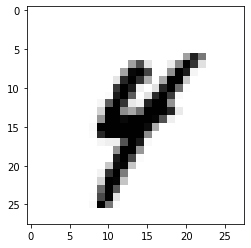

Label: 4


In [4]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(1-img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Model

In [133]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,3**2,3),
#             nn.ReLU(),
            nn.Tanh(),
#             nn.MaxPool2d(3),
            nn.Conv2d(3**2,3**2,3),
            nn.Tanh(),            
#             nn.ReLU(),
            nn.MaxPool2d(3),          
        )
        self.linear = nn.Sequential(
            nn.Linear(3**2*(8)**2, 2**9),
#             nn.Linear(28**2, 2**9),
#             nn.ReLU(),
            nn.Tanh(),
            nn.Linear(2**9, 2**9),
#             nn.ReLU(),    
            nn.Tanh(),            
            nn.Linear(2**9, 10),
        )

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        features = self.conv(x)
#         print(f"{features.shape=}")

#         features = x
        flat = features.view(features.shape[0],-1)
        logits = self.linear(flat)
        return logits
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=576, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [134]:
X = torch.rand(1, 28, 28)
logits = model(X)
print(f"{logits.shape=}")
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

logits.shape=torch.Size([1, 10])
Predicted class: tensor([1])


In [135]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

# Training

In [136]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [137]:
# The cell can be executed multiple times to increase accuracy, the weights will not be reset.

learning_rate = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306479  [    0/60000]
loss: 2.300536  [ 6400/60000]
loss: 2.299259  [12800/60000]
loss: 2.300179  [19200/60000]
loss: 2.291325  [25600/60000]
loss: 2.286699  [32000/60000]
loss: 2.287872  [38400/60000]
loss: 2.287167  [44800/60000]
loss: 2.285358  [51200/60000]
loss: 2.284321  [57600/60000]
Test Error: 
 Accuracy: 27.9%, Avg loss: 2.278982 

Epoch 2
-------------------------------
loss: 2.278295  [    0/60000]
loss: 2.276106  [ 6400/60000]
loss: 2.276128  [12800/60000]
loss: 2.265780  [19200/60000]
loss: 2.265123  [25600/60000]
loss: 2.263448  [32000/60000]
loss: 2.258367  [38400/60000]
loss: 2.235459  [44800/60000]
loss: 2.236384  [51200/60000]
loss: 2.223169  [57600/60000]
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.225855 

Epoch 3
-------------------------------
loss: 2.214646  [    0/60000]
loss: 2.212387  [ 6400/60000]
loss: 2.203739  [12800/60000]
loss: 2.199885  [19200/60000]
loss: 2.194192  [25600/60000]
loss: 2.156218  [32000/600

Confusion matrix (column - correct label, row - prediction):
[[ 954    0   12    4    1   18   20    6    7   11]
 [   0 1103   11    1    5    3    3   18    7    7]
 [   4    2  891   21    6    7    8   30   10    6]
 [   2    5   17  896    1   47    1    3   34   11]
 [   0    1   19    0  902   13   21   11   13   42]
 [   8    1    2   37    1  729   17    0   35   11]
 [   8    4   18    2   14   17  881    0   17    0]
 [   1    1   14   19    1   11    1  918    9   28]
 [   3   18   41   20    5   36    6    4  822    9]
 [   0    0    7   10   46   11    0   38   20  884]]
First row contains images incorrectly classified as 0. The images in the second row classified as 1, and so on.


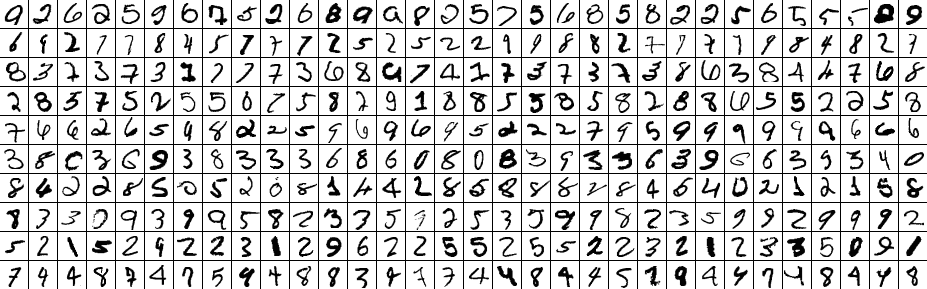

In [104]:
def render_images(images, labels, ncolumns=32):
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    picture = np.empty((10, images.shape[1]+1, ncolumns, images.shape[2]+1), dtype=np.uint8) 
    picture[:] = 255
    for row in range(10):
        mask = labels == row
        masked = images[mask]
        for column in range(min(ncolumns,len(masked))):
            picture[row, :-1, column, :-1] = masked[column]
    picture = picture.reshape((picture.shape[0]*picture.shape[1], picture.shape[2]*picture.shape[3]))[:-1,:-1]
    return Image.fromarray(255-picture, mode='L')

def show_mistakes(dataloader, model):
    confusion_matrix = np.zeros((10,10), dtype=np.int32)
    images, labels = [], []    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            label = pred.argmax(1)
            for k in range(label.shape[0]):
                confusion_matrix[label[k], y[k]] += 1
                if label[k]!=y[k]:
                    images.append((255*X[k]).numpy().astype(np.int8))
                    labels.append(label[k])
    print("Confusion matrix (column - correct label, row - prediction):")
    print(confusion_matrix)
    print(f"First row contains images incorrectly classified as 0. The images in the second row classified as 1, and so on.")                
    return render_images(np.array(images), np.array(labels))
    
show_mistakes(test_dataloader, model)

In [109]:
def invert_model(model, output):
    global inverse_transform
    for layer in list(model.children())[::-1]:
        inverse = inverse_transforms.get(layer.__class__)
        inpt = inverse(layer, output)
        pred = layer(inpt)
        print(f"{tuple(output.shape)} -> {tuple(inpt.shape)}: {torch.linalg.norm(pred-output)} {layer}")        
        output = inpt
    return output
        
def invert_linear(layer, z):
    z = z.view(z.shape[0], -1)
    z = z - layer.bias[None, :]
    z = torch.linalg.lstsq(layer.weight, z.T)[0].T
    return z
        
def invert_tanh(_layer, z):
    return 0.5 * torch.log((1 + z) / (1 - z))

def invert_relu(_layer, z):
    return z

inverse_transforms = {
    nn.Linear: invert_linear,
    nn.Tanh: invert_tanh,
    nn.Sequential: invert_model,
    nn.ReLU: invert_relu,
}


input0.shape=torch.Size([1, 28, 28])
(1, 10) -> (1, 512): 2.9562943382188678e-06 Linear(in_features=512, out_features=10, bias=True)
(1, 512) -> (1, 512): 5.062643685960211e-05 Linear(in_features=512, out_features=512, bias=True)
(1, 512) -> (1, 784): 0.00033711051219142973 Linear(in_features=784, out_features=512, bias=True)
(1, 10) -> (1, 784): 0.0001608082529855892 Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): Linear(in_features=512, out_features=10, bias=True)
)
Target output   [[-2.233774  -2.7454596  1.2372663  1.7833842 -1.4983392  2.159638
  -2.5237408 -1.1519809  3.9729393  1.6604463]]
Obtained output [[-2.2336936 -2.7454479  1.2372802  1.7834145 -1.498461   2.1596599
  -2.523757  -1.1519796  3.9729526  1.6603974]]


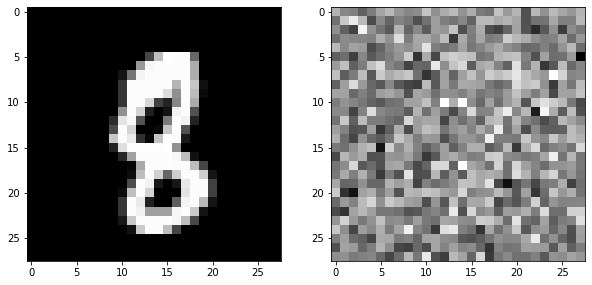

In [110]:
input0 = train_features[1][None]
print(f"{input0.shape=}")
output0 = model(input0)

# output = torch.tensor([-20]*10)[None,:]
# output[0,5] = 10

input1 = invert_model(model, output0).reshape((1,28,28))
output1 = model(input1)
print("Target output  ", output0.detach().numpy())
print("Obtained output", output1.detach().numpy())

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
image0 = input0.detach().squeeze().numpy()
image1 = input1.detach().squeeze().numpy()
ax1.imshow(image0, cmap="gray")
ax2.imshow(image1, cmap="gray")
plt.show()

In [21]:
print(*model.children())

Sequential(
  (0): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (1): Softplus(beta=1, threshold=20)
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(9, 81, kernel_size=(3, 3), stride=(1, 1))
  (4): Softplus(beta=1, threshold=20)
  (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
) Sequential(
  (0): Linear(in_features=324, out_features=512, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=512, out_features=10, bias=True)
)


In [22]:
s1, s2 = model.children()
print(*s1.children())

Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1)) Softplus(beta=1, threshold=20) MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False) Conv2d(9, 81, kernel_size=(3, 3), stride=(1, 1)) Softplus(beta=1, threshold=20) MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
